# Example from the Modelica Conference 2021
Tutorial by Tobias Thummerer, Johannes Stoljar

This example was updated over time to keep track with developments and changes in *FMI.jl*.

🚧 This tutorial is under revision and will be replaced by an up-to-date version soon 🚧

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Josef Kircher, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

## Introduction to the example
FMUs can be simulated in multiple ways using *FMI.jl*. You can use a very simple interface, that offers possibilities that satisfy almost any user requirement. However, if you need to build a custom simulation loop for your use case using the core FMI functions, we show that too.

![svg](https://github.com/thummeto/FMI.jl/blob/main/docs/src/examples/pics/SpringFrictionPendulum1D.svg?raw=true)  

## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.ipynb) there is also a [Julia file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.md) corresponding to the notebook.  

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMIZoo
using Plots

### Simulation setup

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.1
tStop = 8.0
tSave = tStart:tStep:tStop

0.0:0.1:8.0

### Simple FMU Simulation
Next, the FMU model from *FMIZoo.jl* is loaded and the information about the FMU is shown.

In [4]:
# we use an FMU from the FMIZoo.jl
fmu = loadFMU("SpringFrictionPendulum1D", "Dymola", "2022x")
info(fmu)

#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{2e178ad3-5e9b-48ec-a7b2-baa5669efc0c}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:12Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Parameters:			12
		16777216 ["fricScale"]
		16777217 ["s0"]
		16777218 ["v0"]
		16777219 ["fixed.s0"]
		...
		16777223 ["mass.smin"]
		16777224 ["mass.v_small"]
		16777225 ["mass.L"]
		16777226 ["mass.m"]
		16777227 ["mass.fexp"]


	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


### Easy Simulation
In the next commands the FMU is simulated, for which the start and end time and recorded variables are declared. Afterwards the simulation result is plotted. In the plot for the FMU, it can be seen that the oscillation keeps decreasing due to the effect of friction. If one simulates long enough, the oscillation comes to a standstill after a certain time.

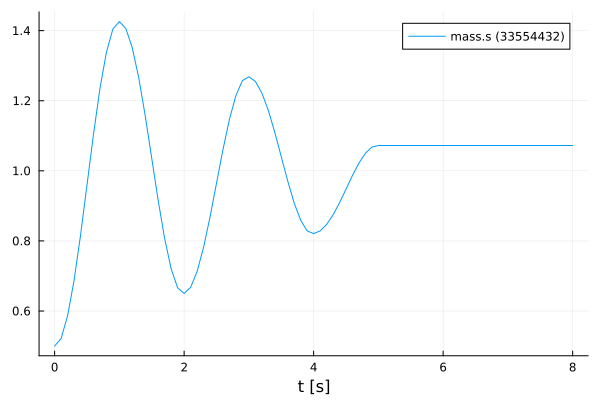

In [5]:
simData = simulate(fmu, (tStart, tStop); recordValues=["mass.s"], saveat=tSave)
plot(simData)

After plotting the data, the FMU is unloaded and all unpacked data on disc is removed.

In [6]:
unloadFMU(fmu)

### Custom Simulation

In the following type of simulation a more advanced variant is presented, which allows intervening more in the simulation process. Analogous to the simple variant, an FMU model must be loaded.

In [7]:
fmu = loadFMU("SpringFrictionPendulum1D", "Dymola", "2022x")

Model name:	SpringFrictionPendulum1D
Type:		1

Next, it is necessary to create an instance of the FMU, this is achieved by the command `fmi2Instantiate!()`.  

In [8]:
instanceFMU = fmi2Instantiate!(fmu)

FMU:            SpringFrictionPendulum1D
    InstanceName:   SpringFrictionPendulum1D
    Address:        Ptr{Nothing} @0x00000242178238e0
    State:          0
    Logging:        false
    FMU time:       -Inf
    FMU states:     nothing

In the following code block, start and end time for the simulation is set by the `fmi2SetupExperiment()` command. Next, the FMU is initialized by the calls of `fmi2EnterInitializationMode()` and `fmi2ExitInitializationMode()`. It would also be possible to set initial states, parameters or inputs at this place in code.

In [9]:
fmi2SetupExperiment(instanceFMU, tStart, tStop)
# set initial model states
fmi2EnterInitializationMode(instanceFMU)
# get initial model states
fmi2ExitInitializationMode(instanceFMU)

0x00000000

The actual simulation loop is shown in the following block. Here a simulation step `fmi2DoStep()` with the fixed step size `tStep` is executed. As indicated in the code by the comments, the input values and output values of the FMU could be changed in the simulation loop as desired, whereby the higher possibility of adjustments arises.

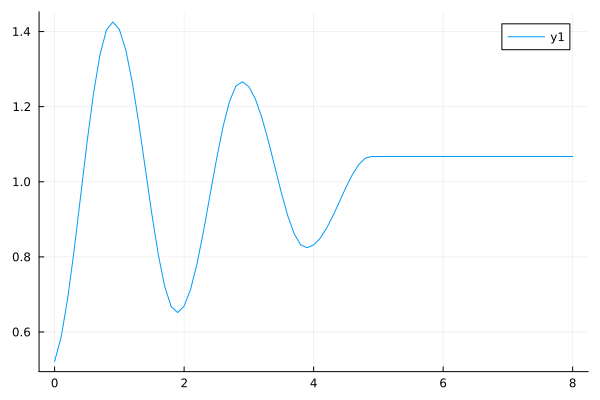

In [10]:
values = []

for t in tSave
    # set model inputs if any
    # ...

    fmi2DoStep(instanceFMU, tStep)
    
    # get model outputs
    value = fmi2GetReal(instanceFMU, "mass.s")
    push!(values, value)
end

plot(tSave, values)

The instantiated FMU must be terminated and then the memory area for the instance can also be deallocated. The last step is to unload the FMU to remove all unpacked data on disc. 

In [11]:
fmi2Terminate(instanceFMU)
fmi2FreeInstance!(instanceFMU)
unloadFMU(fmu)

### Summary

The tutorial has shown how to use the default simulation command and how to deploy a custom simulation loop.